# Clustering Tutorial written by David Ziganto

## Background Information

Unsupervised clustering is often a difficult problem. Almost every data set is unique, so finding a clustering scheme that fits the data, finding the optimal number of clusters, and evaluating the quality of those clusters is no trivial task. However, several methods exist to help answer the following key questions:

1. Does the data have strong underlying structure conducive to clustering?
2. If structure exists, how many clusters?
3. Which clustering algorithm should I use?

Throughout most of this tutorial we will use the canonical data set *ruspini* available in the 'cluster' library. Data set structure and summary below.

In [1]:
library(cluster)
data(ruspini)
str(ruspini)
summary(ruspini)

'data.frame':	75 obs. of  2 variables:
 $ x: int  4 5 10 9 13 13 12 15 18 19 ...
 $ y: int  53 63 59 77 49 69 88 75 61 65 ...


       x                y         
 Min.   :  4.00   Min.   :  4.00  
 1st Qu.: 31.50   1st Qu.: 56.50  
 Median : 52.00   Median : 96.00  
 Mean   : 54.88   Mean   : 92.03  
 3rd Qu.: 76.50   3rd Qu.:141.50  
 Max.   :117.00   Max.   :156.00  

## Step 1: Scale Data
Start by scaling your data so that each column has zero mean and unit standard deviation. This prevents one feature with a large range from dominating the others when the distance calculation is performed.

In [2]:
scaledRuspini <- scale(ruspini)
summary(scaledRuspini)

       x                  y           
 Min.   :-1.66806   Min.   :-1.80743  
 1st Qu.:-0.76649   1st Qu.:-0.72946  
 Median :-0.09442   Median : 0.08158  
 Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.70879   3rd Qu.: 1.01582  
 Max.   : 2.03655   Max.   : 1.31355  

## Step 2: Investigate Underlying Structure
The first question we ask is surely the most important: **is my data a good candidate for clustering?** 

Two methods are presented here to help answer that question. 

### Method 1: t-Distributed Stochastic Neighbors (tSNE)
#### What is it?
A technique for dimensionality reduction that is particularly well suited for visualizing high-dimensional datasets. The technique can be implemented via Barnes-Hut approximations, allowing it to be applied on large, real-world datasets.

#### How does it work?
tSNE visualizes high-dimensional data by giving each data point a location in a two or three-dimensional map. It is a variation of Stochastic Neighbor Embedding that allows optimization, and produces significantly better visualizations by reducing the tendency to lump points together in the center of the map that often renders the visualization ineffective and unreadable. t-SNE is good at creating a map that reveals structure and embedding relationships at many different scales. This is particularly important for high-dimensional inter-related data that lie on several different low-dimensional manifolds, such as images of objects from multiple classes seen from multiple viewpoints.

The baseline version of t-SNE has O(N^2) complexity. Later on, Laurens van der Maaten introduced the O(N log N) version of t-SNE (a.k.a Barnes-Hut-SNE).

Bottomline: tSNE helps to answer the question: "*is my data a good candidate for clustering?*".

Before we apply this technique to the ruspini data set, let's see what a randomized data set NOT suitable for clustering looks like with tSNE.

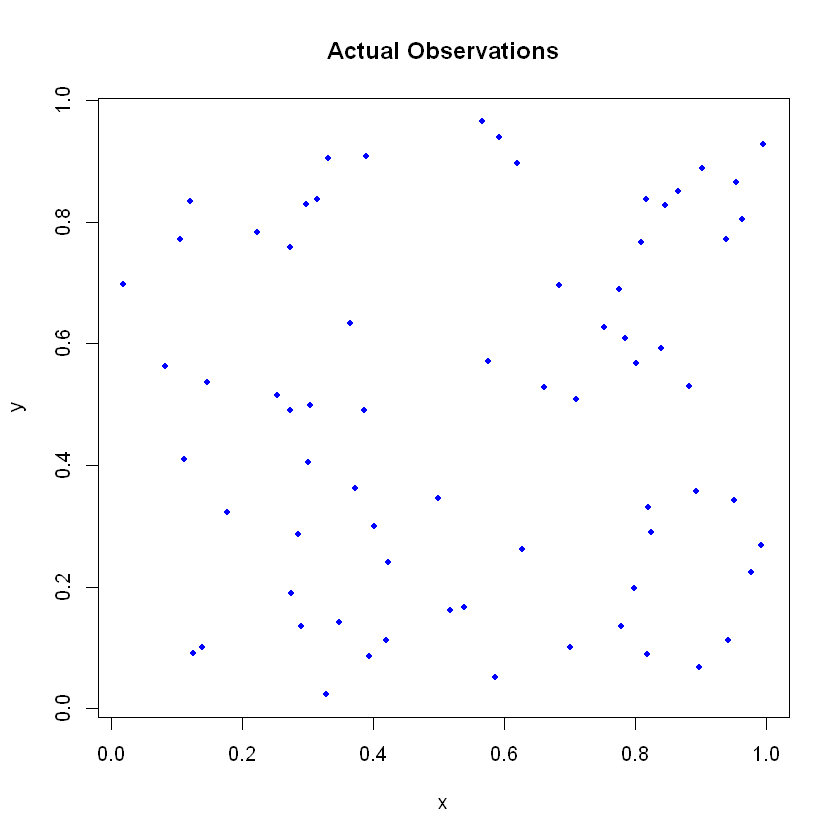

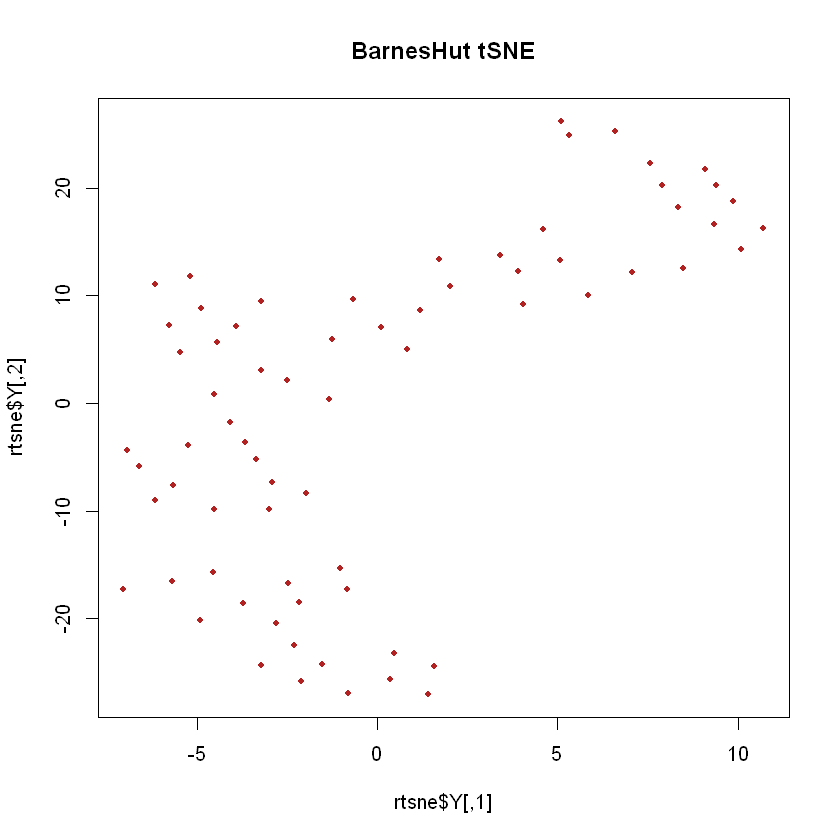

In [26]:
library(Rtsne)

set.seed(23)
x <- runif(70, min = 0, max = 1)
y <- runif(70, min = 0, max = 1)
myXY <- cbind(x,y)
plot(x, y, main="Actual Observations", pch=20, col="blue")

set.seed(42)
rtsne <- Rtsne( as.matrix(myXY), theta = 0.4, perplexity = 15, check_duplicates = F, verbose = F )
plot(rtsne$Y, main="BarnesHut tSNE", pch=20, col = "firebrick")

The first plot above shows the distribution of actual randomized observations. The second plot entitled "Barned Hut tSNE" shows that there is no underlying structure to be clustered. Let's look at another example, this time showing what tSNE would look like if the data has underlying structure suitable for clustering. 

We'll be using the *rupini* dataset available in library 'cluster'. We'll start by plotting the data and then we'll investigate tSNE plot.

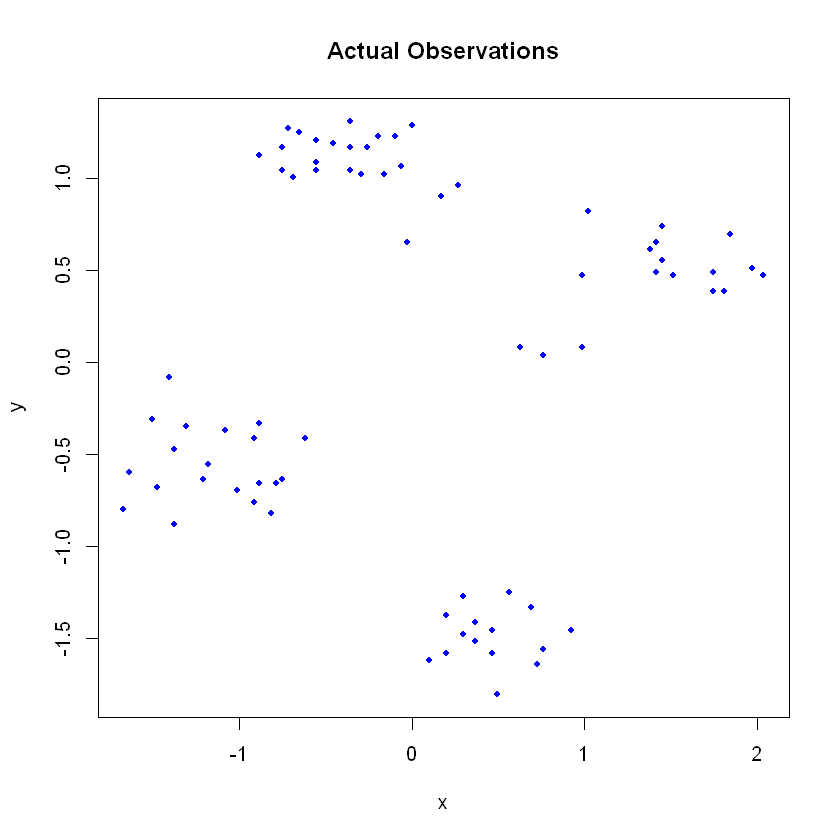

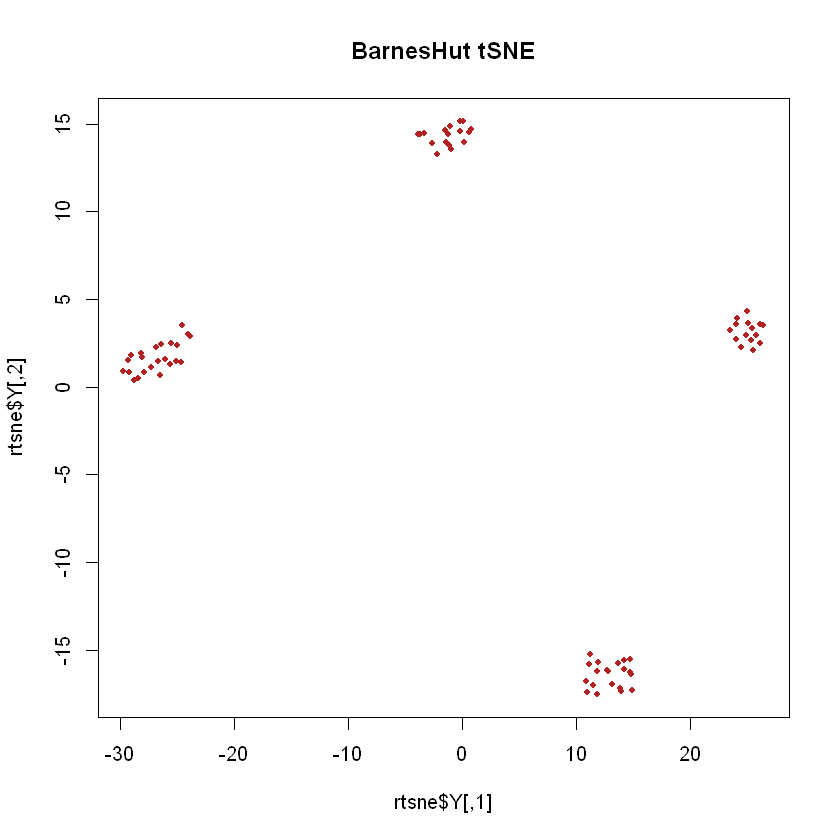

In [4]:
plot(scaledRuspini, pch = 20, col="blue", main = "Actual Observations")

set.seed(42)
rtsne <- Rtsne( scaledRuspini, theta = 0.4, perplexity = 15, check_duplicates = F, verbose = F )
plot(rtsne$Y, main="BarnesHut tSNE", pch = 20, col = "firebrick")

While tSNE may not necessarily help us determine the optimal number of clusters, it does indicate if there exists underlying structure that can be clustered. In this example we can clearly see segmentation; this data is definitely clusterable. 

**Implementation details:** *theta* is a measure that determines the level of approximation. A *theta* equal to 0 would be exact tSNE whereas a value of 0.5 would be less accurate but much faster. The user also selects the number of iterations. Setting this value equal to 1,000 is typical as it usually ensures convergence of the error value, which can be output every 50 iterations by setting verbose = TRUE. 

### Method 2: Visual Analysis for cluster Tendency (VAT)
VAT shows whether there exists a strong structure conducive to clustering. It's another way to tease out underlying structure within the data, if in fact it exists. If it does not, then there's no need to attempt clustering.

Let's start with randomized data so we have a reference.

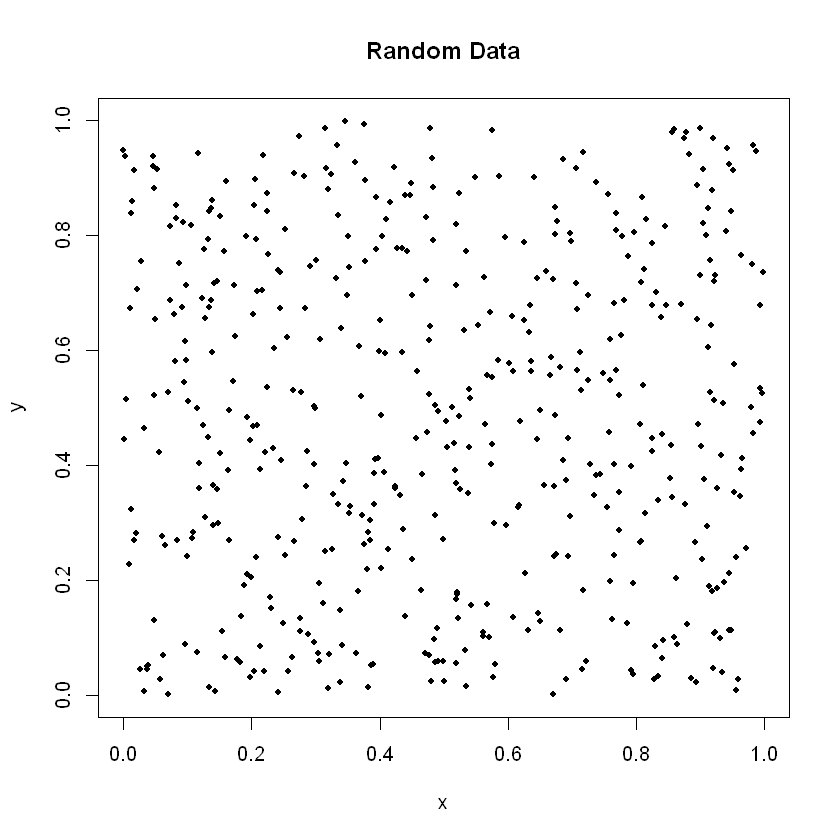

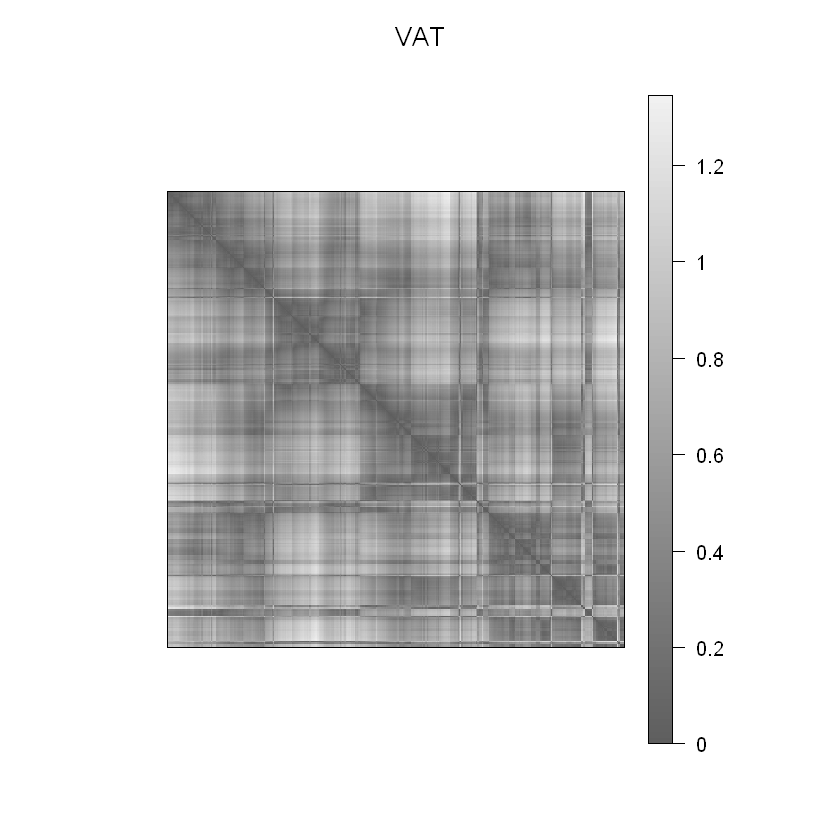

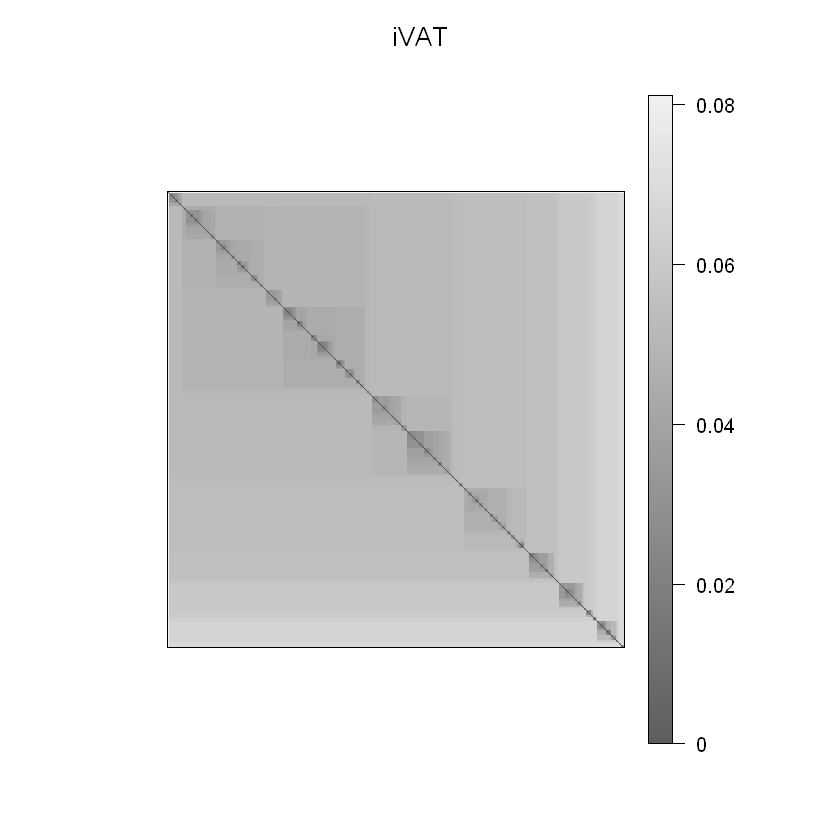

In [5]:
library(seriation)
randomData <- matrix(runif(2*500), ncol=2, dimnames = list(NULL, c("x", "y")))
plot(randomData, pch=20, main = "Random Data")
randDataDist <- dist(randomData)
VAT(randDataDist, main = "VAT")  ## fast method
iVAT(randDataDist, main = "iVAT")  ## uses largest distances in all possible paths between objects. 

Now let's use this method on our ruspini data, which we know clusters well. Notice the stark differences in the plots.

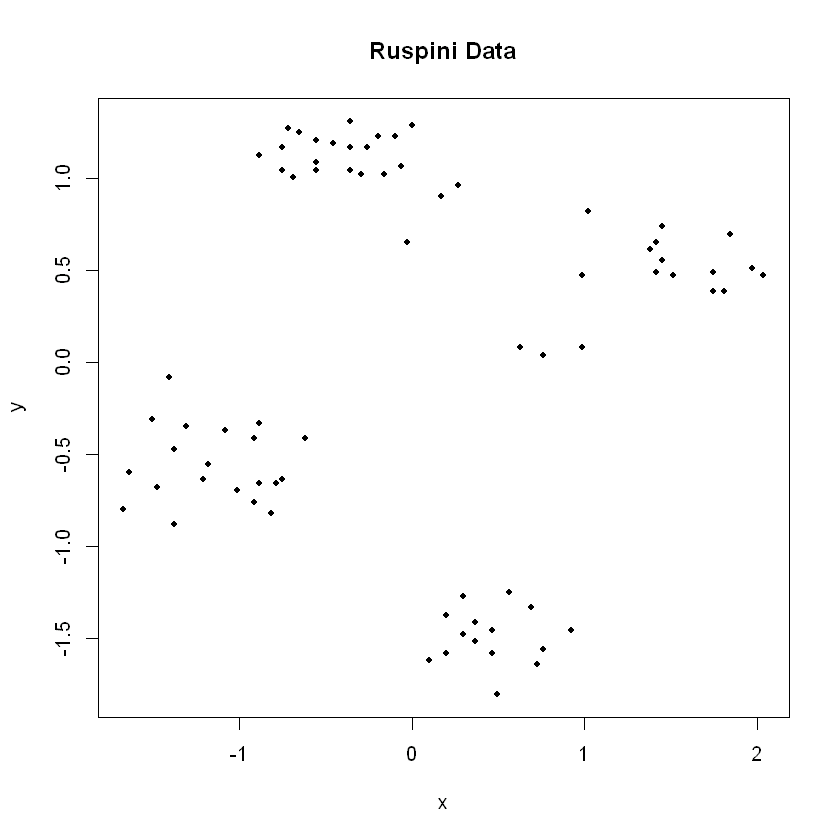

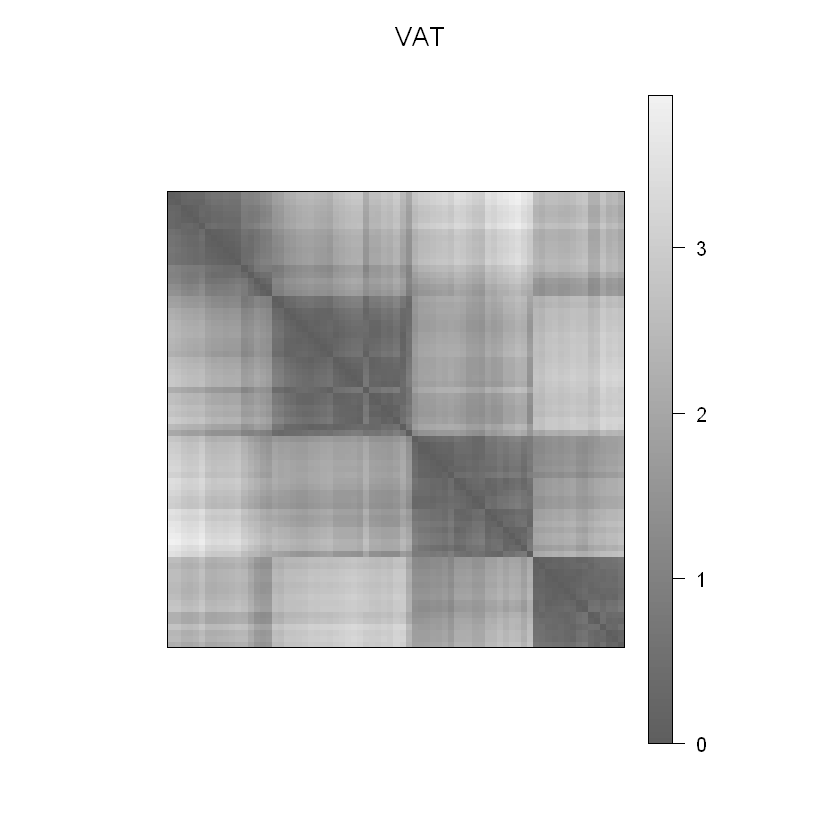

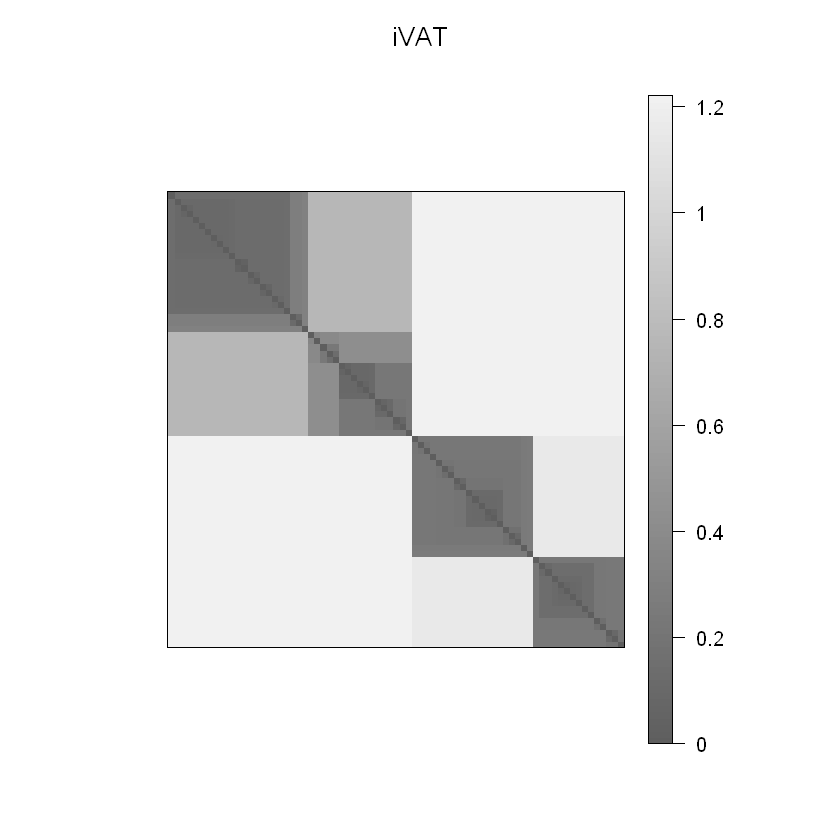

In [6]:
plot(scaledRuspini, pch=20, main = "Ruspini Data")
d <- dist(scaledRuspini)
VAT(d, main="VAT")  
iVAT(d, main="iVAT")  

## Step 3: Determine Number of Clusters

### Run *pamk* Algorithm
What is *pamk*? It's an algorithm that helps us to determine the optimal number of clusters. It does this by partitioning the data space using medoids. A medoid can be defined as the object of a cluster whose average dissimilarity to all the objects in the cluster is minimal; it is the most centrally located point in the cluster. To find the optimal number of clusters, pamk calculates the optimum average silhouette width or Calinski-Harabasz index for a range of *k* (# of clusters) set by the user. The Duda-Hart test can be used to determine whether there should be more than one cluster.  

CLARA, which stands for Clustering for Large Applications, extends the k-medoids approach for a large number of objects. CLARA works by clustering a sample from the dataset and then assigns all objects in the dataset to these clusters. Essentially, CLARA makes pamk run much more quickly. CLARA is appropriate when the number of observations > 2,000.

Let's apply pamk to our scaled ruspini data set and plot the results. We'll see two plots. The first will show optimal number of clusters and which points are assigned to which cluster. The second plot will be a silhouette plot giving us more detail about how well clustered the data is.

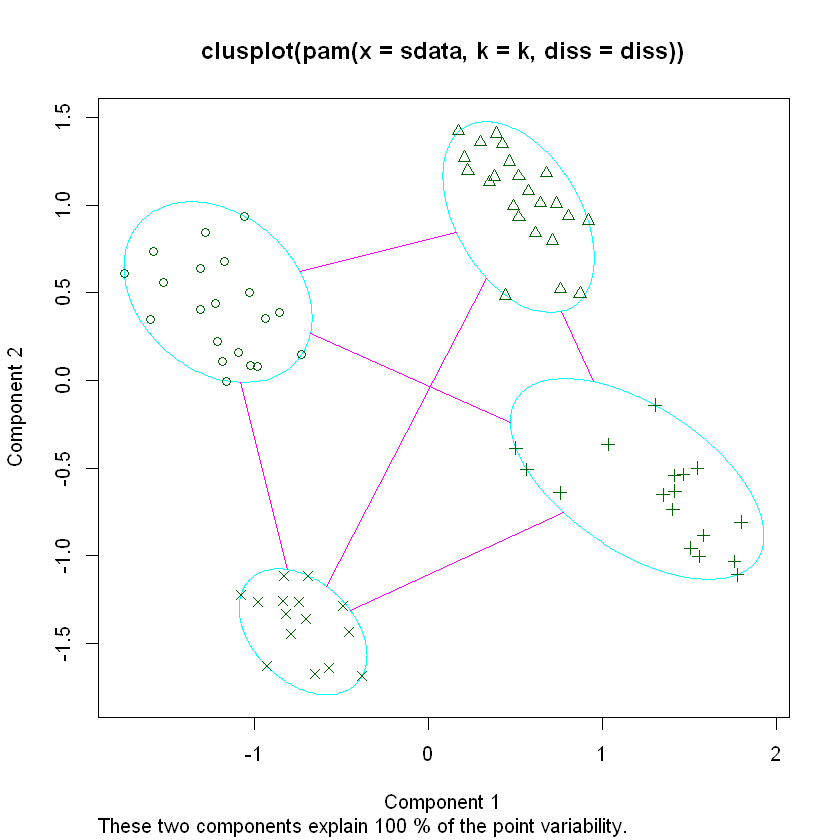

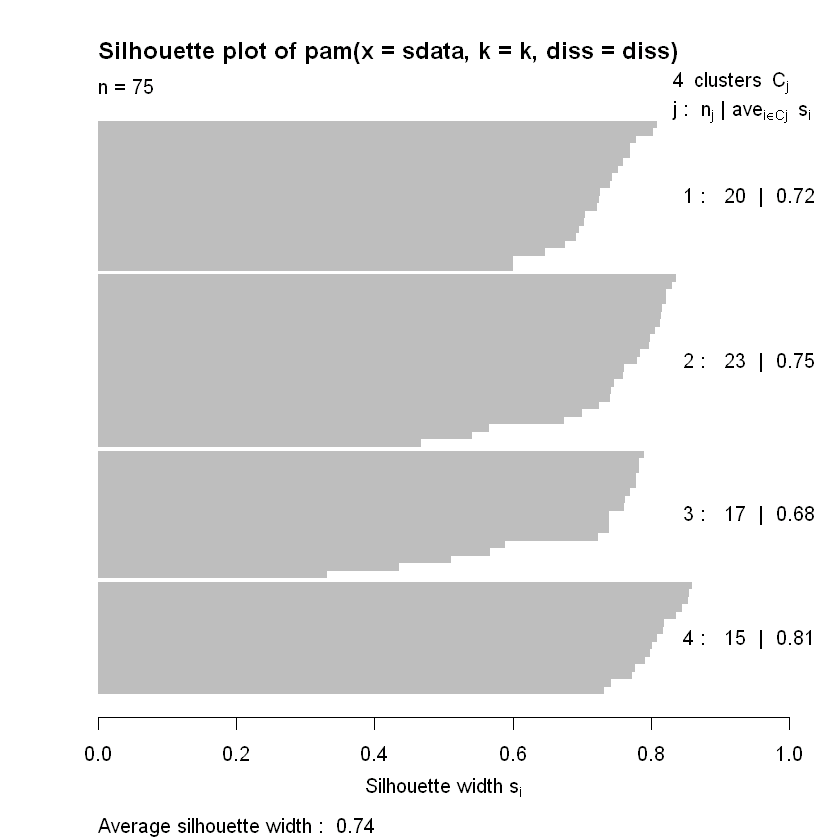

In [7]:
library(fpc)
pamk.result <- pamk(scaledRuspini, krange = 2:10, usepam = TRUE)
plot(pamk.result$pamobject)

### Silhouette Plots 
Simply put, a silhouette plot depicts how well each object lies within its cluster. It is a measure of how similar an object is to its own cluster as compared to other clusters. Silhouette values range from -1 to 1, where a high positive value indicates that the object is well matched to its own cluster and badly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. However, if many points have a low or negative value, then the clustering configuration may have too many or too few clusters. See table below for more details about silhouette width and its corresponding interpretation.

Silhouette Width | Interpretation
--- | ---
0.71-1.0 | A strong structure has been found
0.51-0.70 |	A reasonable structure has been found
0.26-0.50 |	The structure is weak and could be artificial
< 0.25 | No substantial structure has been found

In the silhouette plot above we see four excellent clusters, each with a width roughly 0.71 or above, Couple that with the fact that the total average silhouette width is 0.74, which means we can feel confident four clusters is a good representation.

### Heuristic Indices (optional)
There exist a number of heuristic indices to help us figure out how many clusters to target. The first two methods usually do an excellent job of this, but if you're looking for additional rigor, feel free to leverage these indices. See **NbClust** library documentation for parameter and index specifics.

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


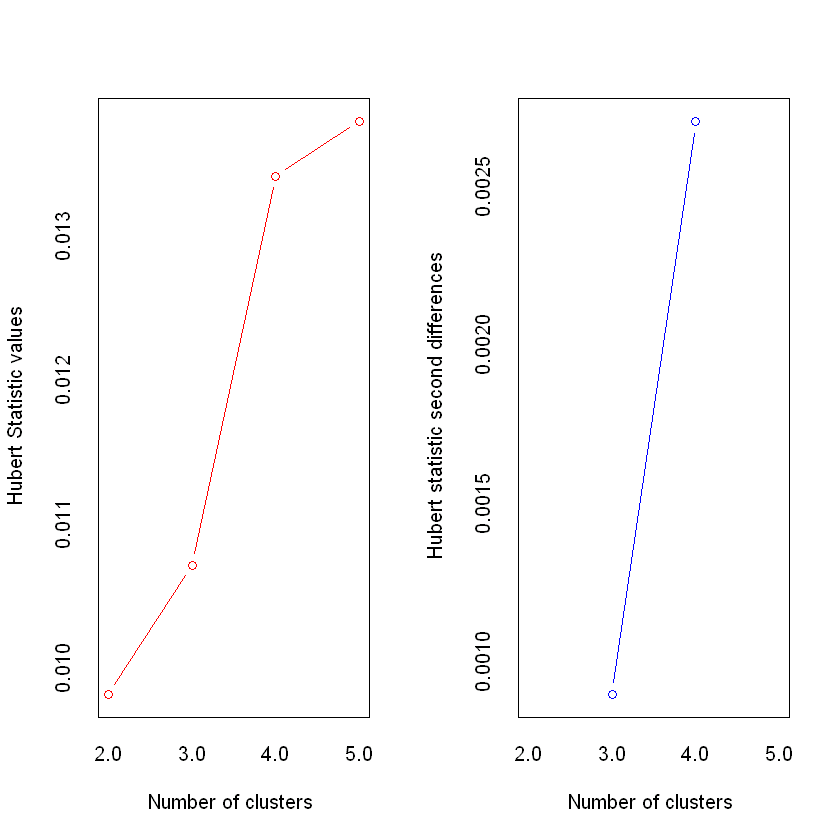

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 1 proposed 2 as the best number of clusters 
* 2 proposed 3 as the best number of clusters 
* 19 proposed 4 as the best number of clusters 
* 1 proposed 5 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  4 
 
 
******************************************************************* 


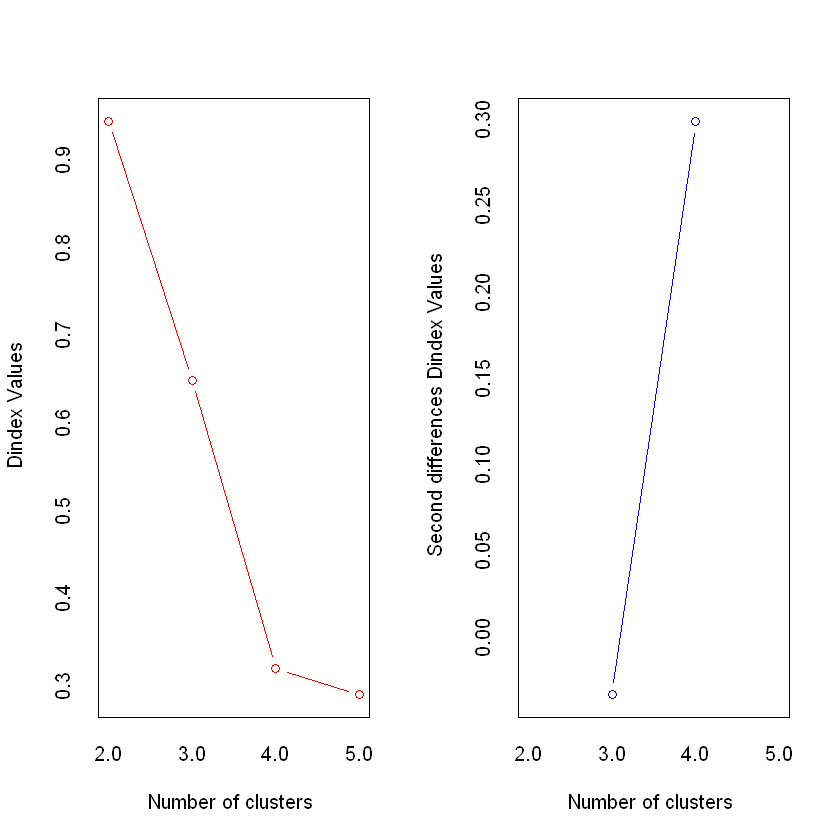

In [8]:
library(NbClust)
nb <- NbClust(data = scaledRuspini, distance = "euclidean", 
              min.nc = 2, max.nc = 5, 
              method = "single", index = "all")

The takeaway: an overwhelming majority of indices recommend four clusters. It is interesting to note that not every index made this recommendation, however.

It is common practice to let the majority select the number of clusters. Another method often used is to look at a subset of indices. For example, an often cited study by Milligan and Cooper (1985) ranks indices, allowing the data practitioner to select, say, the top five indices from that study. 

### Gaussian Mixture Model (optional)
A Gaussian Mixture Model (GMM) is a parametric probability density function represented as a weighted sum of Gaussian component densities. GMM's are fitted via the Expectation-Maximization (EM) algorithm or Maximum A Posteriori (MAP) estimation from a well-trained prior model for model-based clustering, classification, and density estimation, including Bayesian regularization and dimension reduction.

Package 'mclust' version 5.2
Type 'citation("mclust")' for citing this R package in publications.


----------------------------------------------------
Gaussian finite mixture model fitted by EM algorithm 
----------------------------------------------------

Mclust EEI (diagonal, equal volume and shape) model with 5 components:

 log.likelihood  n df       BIC       ICL
      -91.26485 75 16 -251.6095 -251.7486

Clustering table:
 1  2  3  4  5 
20 23  3 14 15 

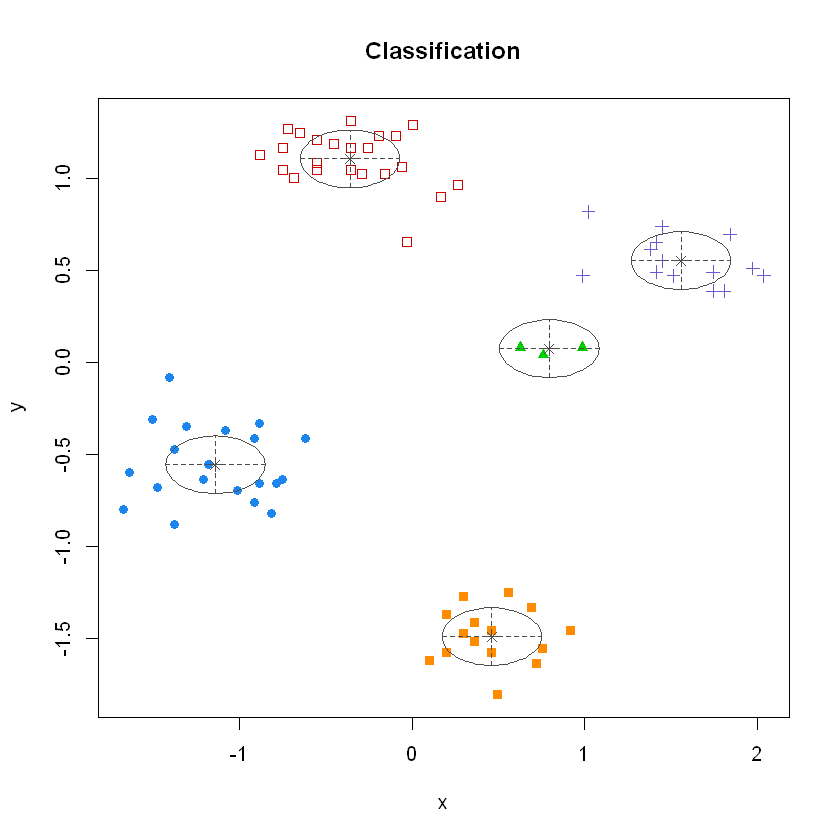

In [9]:
library(mclust, verbose = F);
mc <- Mclust(scaledRuspini)
summary(mc)
plot(mc, what = "classification")

GMM recommends 5 clusters as depicted above. A question may arise: why does GMM recommend 5 clusters while others recommend 4 or 3 or 2, and so on? Again, there is no perfect answer. Unsupervised learning is not a perfect science. As such, the best we can do is to know our data extremely well and leverage a number of heuristics to guide our models. 

## Recap
So far we know how to look at underlying data structure to see if clustering is even appropriate, and, if so, how many clusters should we be targeting. The next step is to detect outliers and run Principal Components Analysis (PCA), if appropriate. Then we can implement a clustering algorithm. On to outlier detection and PCA.

## Step 4: Outlier Detection & PCA
Outliers are often considered as some sort of error or noise. However, they may carry important information. Failing to detect outliers may adversely lead to model misspecification, biased parameter estimation, and incorrect results. It is therefore important to identify them prior to modeling and analysis.

Note: I show some methods to detect outliers here, but I will not eliminate them in the subsequent examples.

While not shown here, consider Principal Component Analysis (PCA) before clustering. It helps reduce the dimensionality of the data and sometimes allows you to visualize the data in 2D or 3D.

### Outlier Detection & Removal


Attaching package: 'dbscan'

The following object is masked from 'package:fpc':

    dbscan



[1] 1.1125507 1.0450700 1.1081512 1.0565938 1.2148254 0.9069949 1.3300434
 [8] 0.9681005 0.9459990 1.0043444 1.0283220 1.2371291 1.1405621 0.9537588
[15] 0.9716911 1.0401373 0.9927175 0.9738532 0.9755169 1.3686474 1.0431788
[22] 1.1286469 0.9800394 0.9843661 1.0055494 0.9634670 0.9990997 0.9937024
[29] 1.0002172 0.9689082 0.9879616 1.0362640 0.9511446 1.0161986 0.9832222
[36] 0.9798503 1.0886397 1.0953725 1.1549652 1.2132232 1.5392556 1.4312910
[43] 1.4064557 2.0704446 1.8878935 1.9069148 1.9571488 1.2869770 1.0200972
[50] 0.9206162 0.9742836 1.0271161 1.1171265 1.0243148 1.0614294 0.9771255
[57] 1.0076168 1.0129186 1.0286599 1.0242479 1.5746212 1.3129422 1.0503847
[64] 1.0641159 1.0076312 1.2097745 0.9937472 1.3772321 0.9521640 0.9444276
[71] 0.9696607 1.0348306 1.2863969 1.2866527 1.1913619

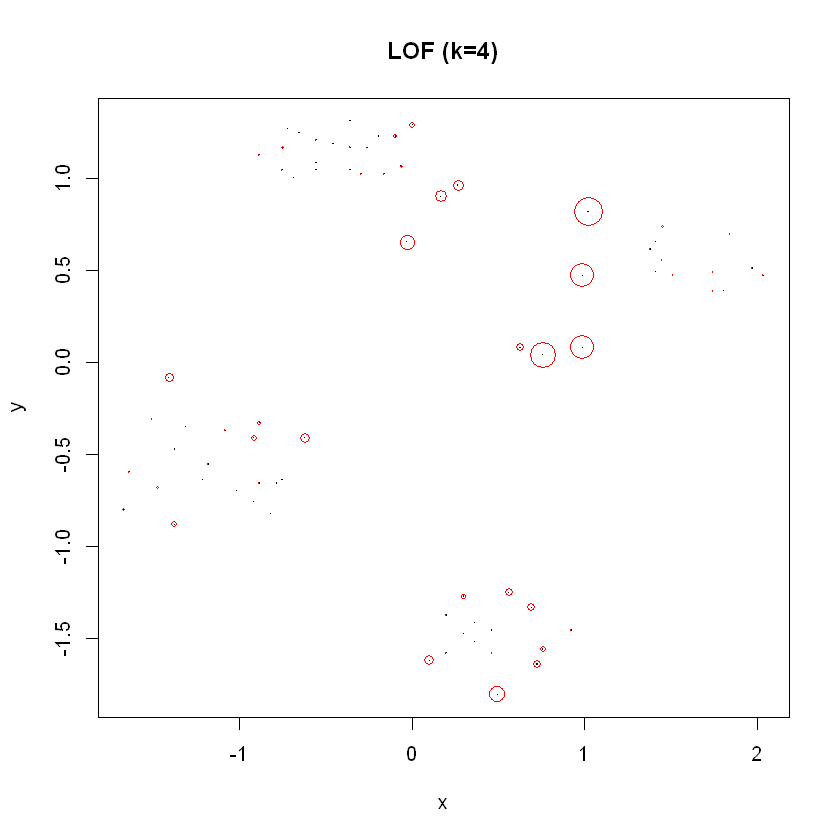

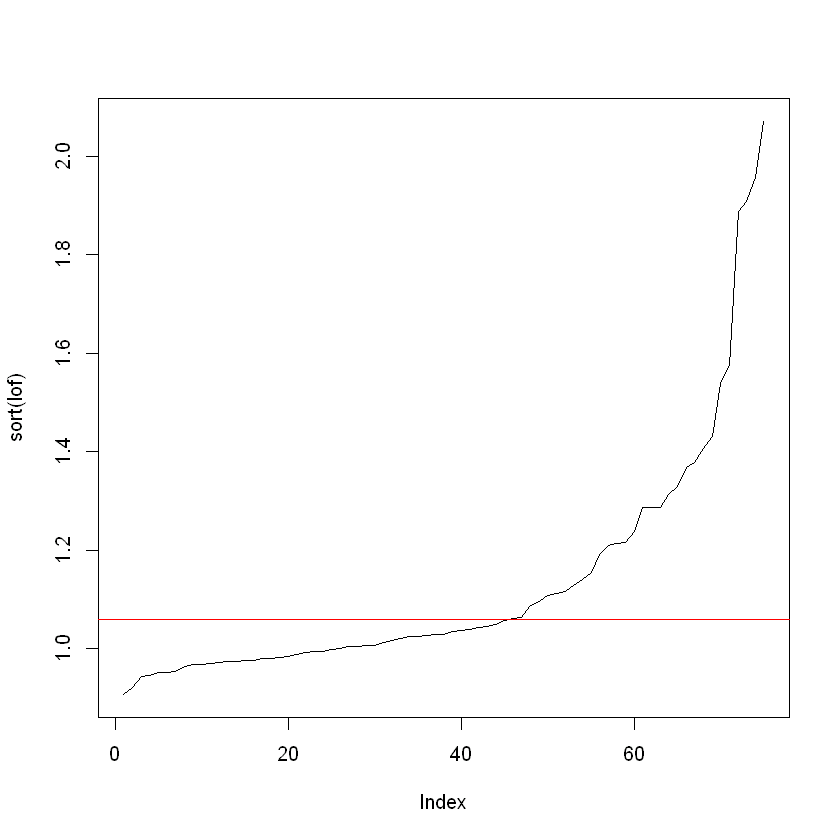

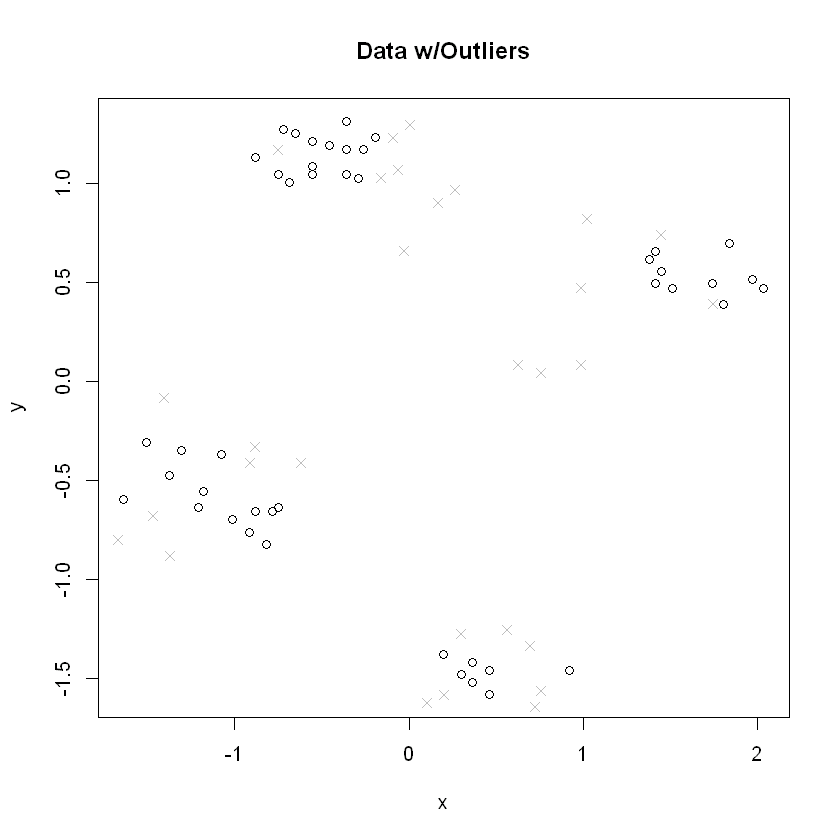

In [10]:
library(dbscan, verbose = F);
lof <- lof(scaledRuspini, k = 4)
lof
plot(scaledRuspini, pch = ".", main = "LOF (k=4)")
points(scaledRuspini, cex = (lof-1)*3, pch = 1, col="red")
## Find outliers by identifying knee
plot(sort(lof), type = "l")
abline(h = 1.06, col = "red")
plot(scaledRuspini[lof < 1.06,], main = "Data w/Outliers")
points(scaledRuspini[lof >= 1.06,], col = "grey", pch = 4)

The first graph visually identifies outliers. The larger the red circle around a data point, the more likely it is to be an outlier. 

The second graph helps us whether a data point is an outlier. We utilize the knee method, which identifies a threshold at approximately 1.06. 

The third and final graph plots all points but X represents those data points that exceed the 1.06 threshold and therefore represent outliers.

## Step 5: Clustering
### Types of Clustering Algorithms

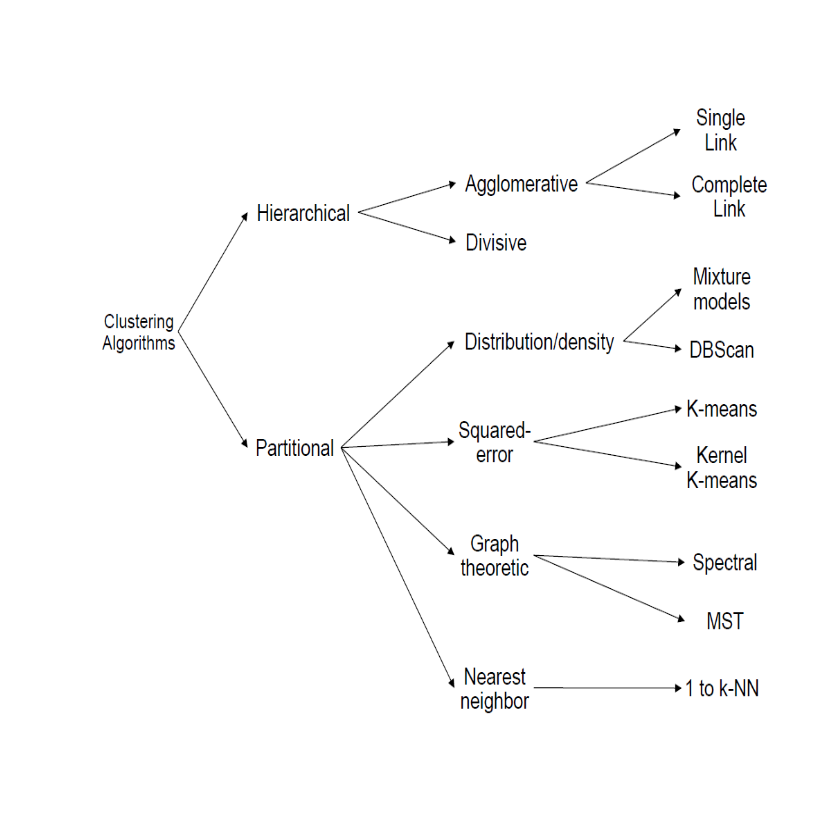

In [11]:
library(png)
img <- readPNG("H:/ClusterHierarchy.png")
plot(1:2, type='n', xlab = "", ylab = "", axes = F)
lim <- par()
rasterImage(img, lim$usr[1], lim$usr[3], lim$usr[2], lim$usr[4])

As you can see from the picture above, there are many clustering methods. Each has its place. Knowing which to use is a matter of experimentation and experience. We will discuss a few methods, including pros and cons.

### Approaches to Clustering
Clustering can be approached in numerous ways. First, represent samples by feature vectors. Then define a distance measure to assess the closeness between data. Closeness can be measured in many ways like defining the distance based on various norms for example. Euclidean distance, cosine distance, and correlation are a few other distance measures. See "Distance Measure and Linkage" tutorial or search the web for more details. The final step could be any of the following:

* Define an objective function to assess clustering quality and then optimize
* Perform clustering on pair-wise distances
* Use statistical model based clustering

Let's look at a few examples.

### Hierarchical Clustering
Hierarchical clustering groups data over a variety of scales by creating a cluster tree or dendrogram. The tree is not a single set of clusters, but rather a multilevel hierarchy, where clusters at one level are joined as clusters at the next level. This allows you to decide the level or scale of clustering that is most appropriate for your application. 

**Pros**

* Easy
* Fast
* Well-known and accepted
* Does not require user to select number of clusters
* Clusters may correspond to meaningful taxonomies (store locations, sales volumes, etc)
* Scalable for large data sets
* Can be configured to run on multiple processors concurrently which keeps execution time linear

**Cons**

* Distance metric unclear sometimes
* Cannot handle partially observed data
* No uncertainty about tree structure
* Sensitive to noise and outliers
* Difficulty handling different sized clusters and irregular shapes

Let's see an example with our ruspini data.


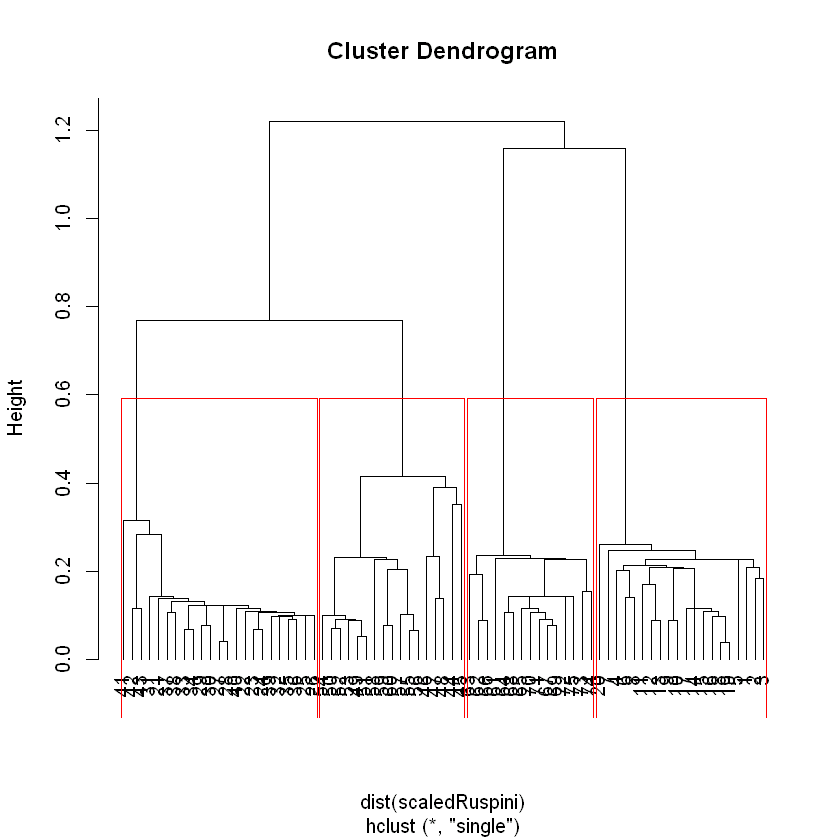

In [12]:
hc <- hclust(dist(scaledRuspini), method="single")
plot(hc, hang = -1)
rect.hclust(hc, k=4) ## cut tree into 4 clusters
groups <- cutree(hc, k=4)

Ensure optimal number of clusters found. See method below.

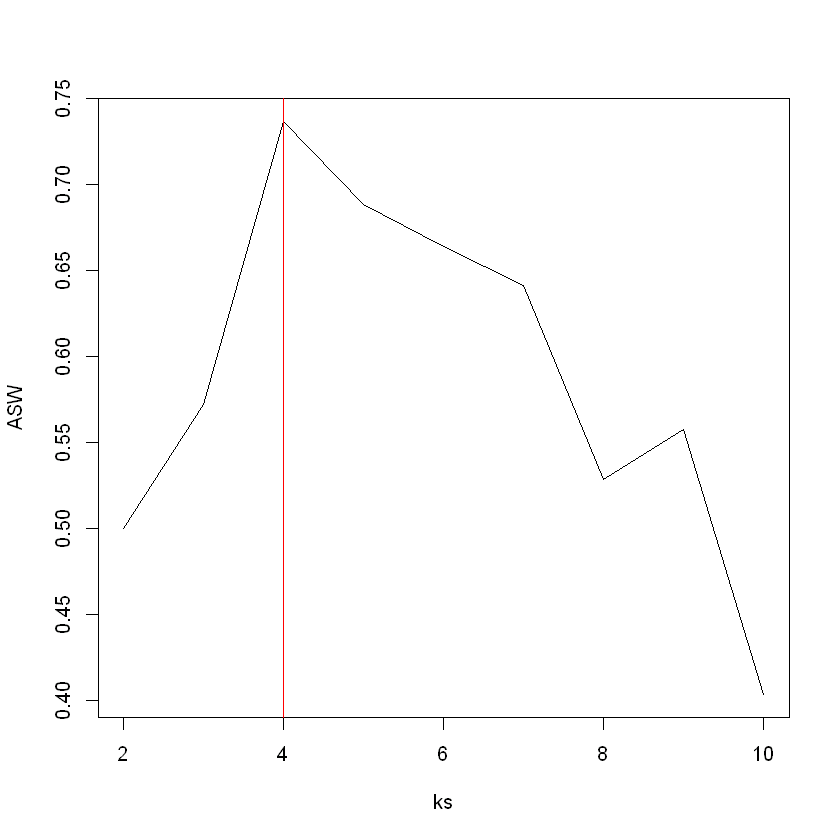

In [13]:
ks <- 2:10
ASW <- sapply(ks, FUN=function(k) {
  cluster.stats(dist(scaledRuspini), cutree(hc, k))$avg.silwidth
})
plot(ks, ASW, type="l")
abline(v=4, col="red")

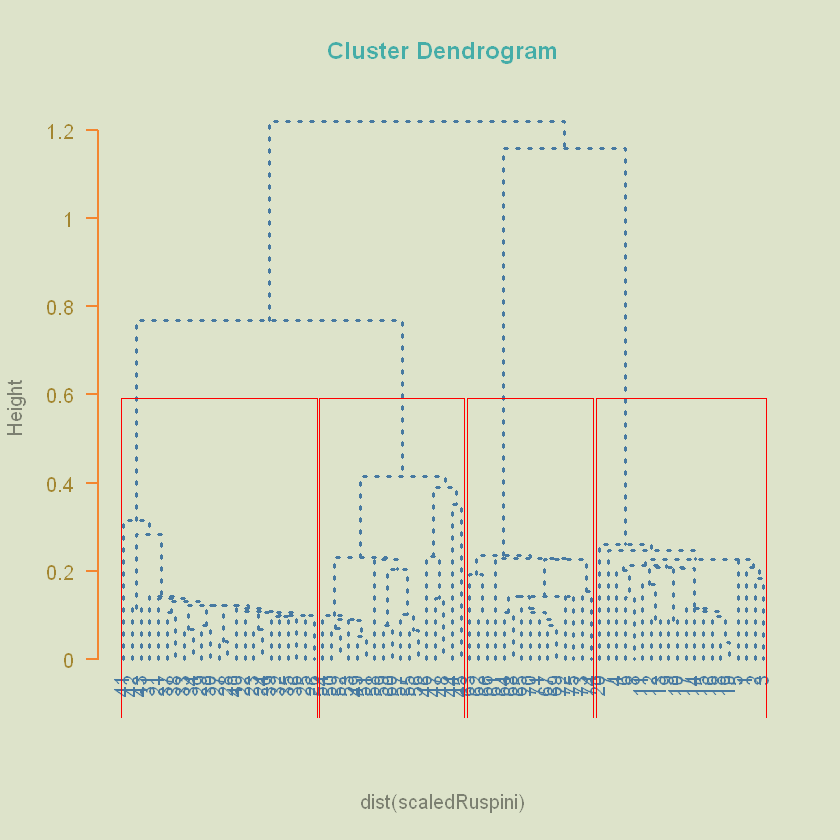

In [14]:
# prettyier version
op = par(bg = "#DDE3CA")
plot(hc, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", 
    col.axis = "#F38630", lwd = 3, lty = 3, sub = "", hang = -1, axes = FALSE)
# add axis
axis(side = 2, at = seq(0, 1.2, 0.2), col = "#F38630", labels = FALSE, 
    lwd = 2)
# add text in margin
mtext(seq(0, 1.2, 0.2), side = 2, at = seq(0, 1.2, 0.2), line = 1, 
    col = "#A38630", las = 2)
rect.hclust(hc, k=4) ## cut tree into 4 clusters
groups <- cutree(hc, k=4)

### Partitional Clustering
Partitional clustering divides data objects into clusters such that each data object is in exactly one cluster. There is no nesting of clusters as there is in hierarchical clustering. 

Many partitional clustering algorithms exist. For simplicity purposes we will focus on some of the most common, including k-means, DBSCAN, Spectral, and Gaussian Mixture Models.

#### k-means

k-means clustering is a popular method of for cluster analysis in data mining. k-means clustering aims to partition *n* observations into *k* clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

**Pros**

* Easy
* Fast for low dimensional data
* Can find sub-clusters

**Cons**

* Cannot handle data of non-spherical shape, different sizes, or different densities
* Cannot identify outliers
* Restricted to data which has the notion of a center (a.k.a centroid)

Let's apply k-means to ruspini.

K-means clustering with 4 clusters of sizes 17, 20, 15, 23

Cluster means:
           x          y
1  1.4194387  0.4692907
2 -1.1385941 -0.5559591
3  0.4607268 -1.4912271
4 -0.3595425  1.1091151

Clustering vector:
 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  4  4  4  4  4  4 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 
 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  1  1  1  1  1  1  1  1  1 
53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 
 1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 

Within cluster sum of squares by cluster:
[1] 3.641276 2.705477 1.082373 2.658679
 (between_SS / total_SS =  93.2 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

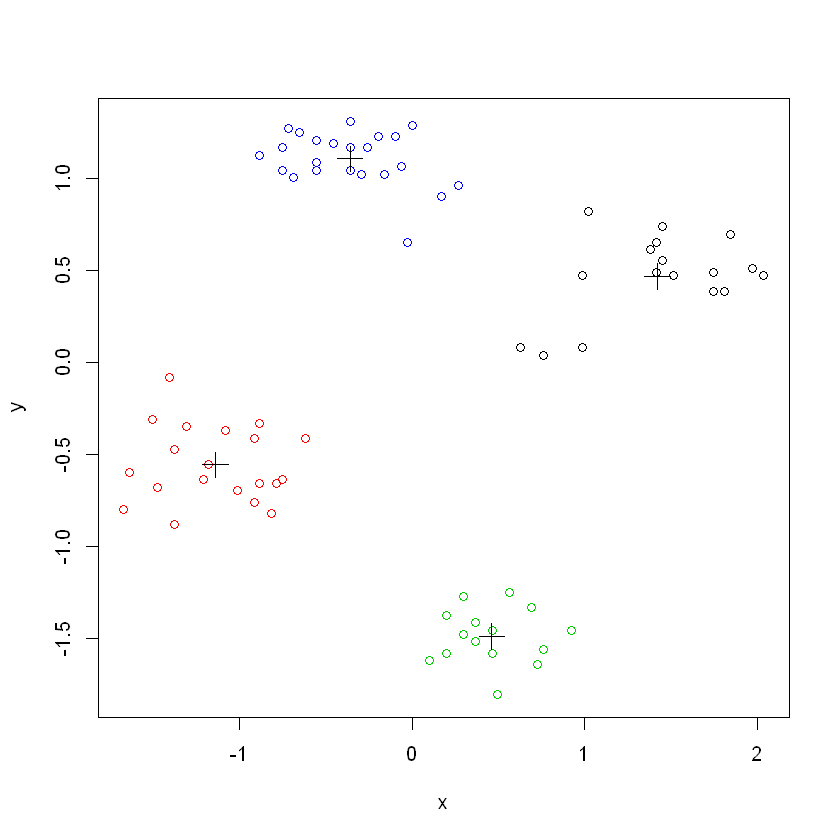

In [15]:
set.seed(15)
km <- kmeans(scaledRuspini, centers=4, nstart=10)
km
plot(scaledRuspini, col=km$cluster)
points(km$centers, pch=3, cex=2) # add the centroids

In this case, k-means does a decent job identifying the four clusters. Keep in mind that k-means is adept when clusters are well separated and roughly spherical. If those conditions can't be met, you're better off utilizing another algorithm. The advantage of k-means is that it is relatively fast. The disadvantages are numerous, however, especially with regards to real-world data.

,x,y
1,1.4194387,0.4692907
2,-1.1385941,-0.5559591
3,0.4607268,-1.4912271
4,-0.3595425,1.1091151


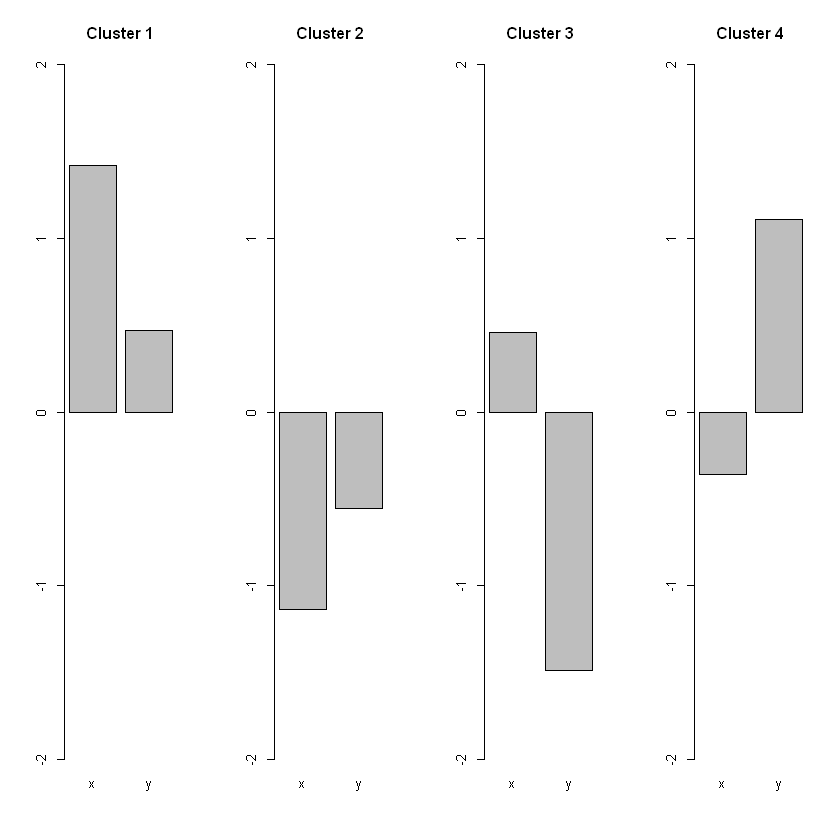

In [16]:
km$centers
def.par <- par(no.readonly = TRUE) # save default, for resetting...
layout(t(1:4)) # 4 plots in one chart
for(i in 1:nrow(km$centers)) barplot(km$centers[i,], ylim=c(-2,2), main=paste("Cluster", i))
par(def.par)  #- reset to default

The table above shows centroid centers; the chart graphically shows the x and y values of those centers via barplot.

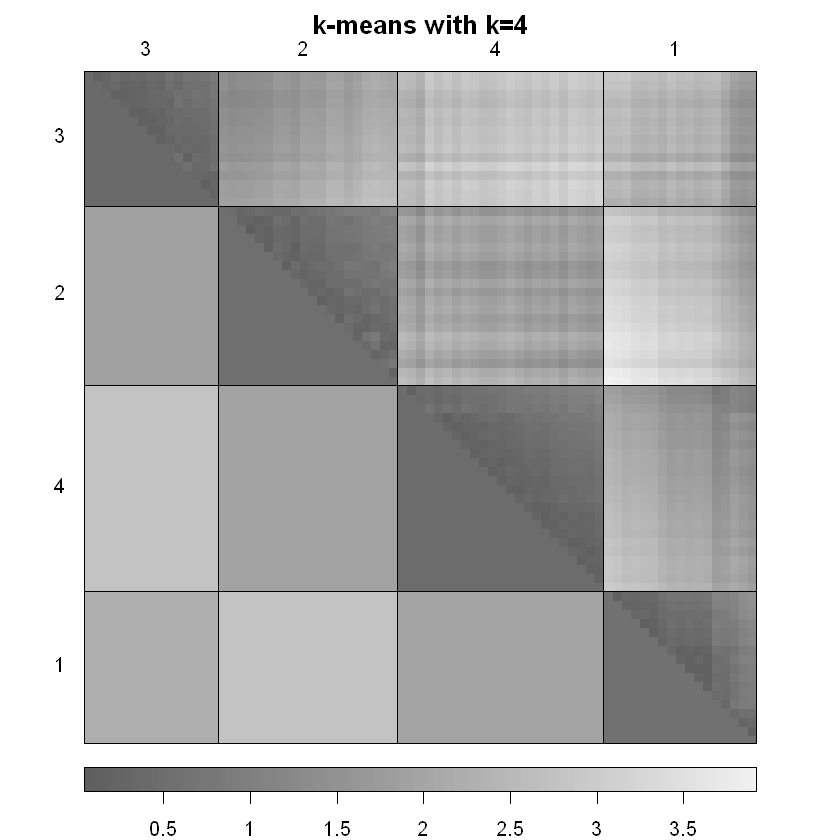

In [17]:
dissplot(dist(scaledRuspini), labels=km$cluster, options=list(main="k-means with k=4"))

Dissimilarity plot above. Higher values = higher dissimilarity. Correspondingly, lower values = higher similarity.

#### DBSCAN
DBSCAN is a density-based clustering algorithm.

DBSCAN takes three parameters: a data matrix or dist object, size of epsilon neighborhood (eps), and minimum number of points in eps region (minPts). Choosing MinPts is a trial-and-error process. A low value for minPts means clusters will include more noise. Epsilon can be chosen by finding the knee in a kNN distance plot. 

**Pros**

* Fast for low dimensional data
* Discovers clusters of arbitrary shapes
* Robust to noise (outlier detection)

**Cons**

* Sensitive to clustering parameters minPts and eps
* Not partitionable for multi-processor systems
* Fails to identify clusters if density varies or if data set is too sparse

Let's set **minPts=3** and explore **epsilon**.

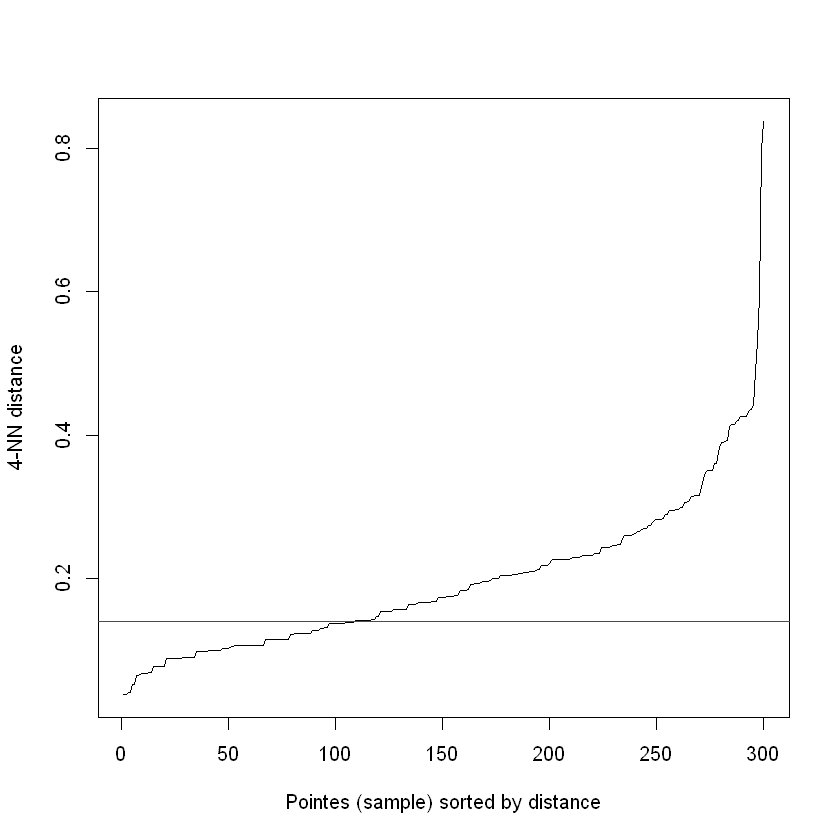

In [18]:
#suppressWarnings(library(dbscan));
kNNdistplot(scaledRuspini, k = 4)
abline(h=.14, col="red")

It appears that **eps ~ 0.14**, so let's use that value.

In [19]:
library(fpc)
set.seed(100)
db <- dbscan(scaledRuspini, eps=.14, minPts=3)
db

dbscan Pts=75 MinPts= eps=0.14

 0  1  2  3  4  5 
36  6 19  6  3  5 

The table above needs explanation. The numbers running along the top (0-5) represent cluster designation. So we end up with 6 clusters.

Let's make two plots. The first will exclude outliers. The second will include outliers which will be colored black.

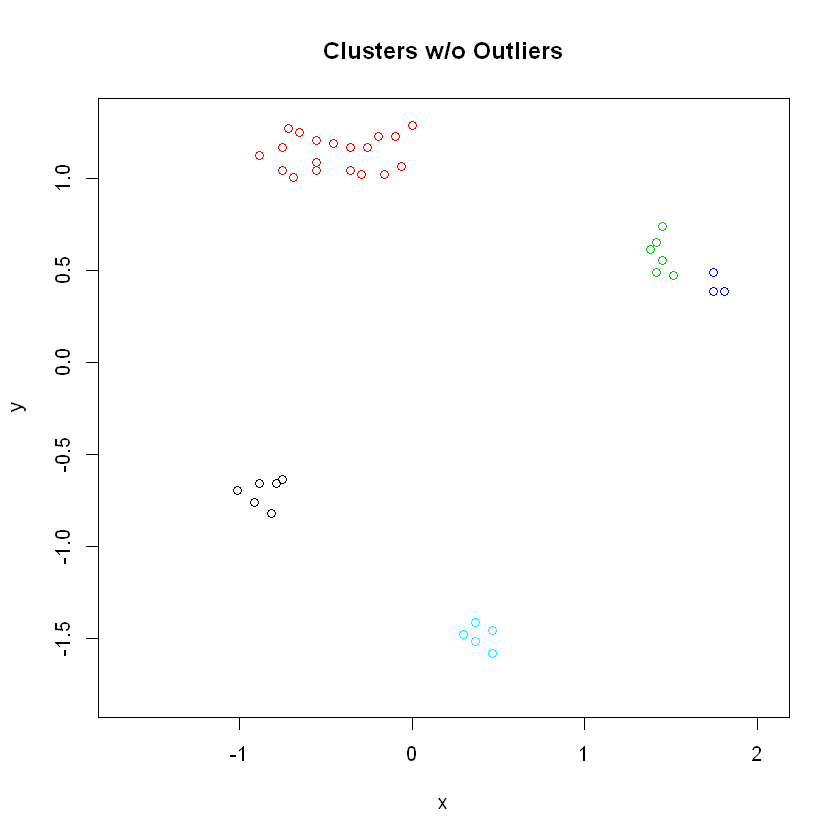

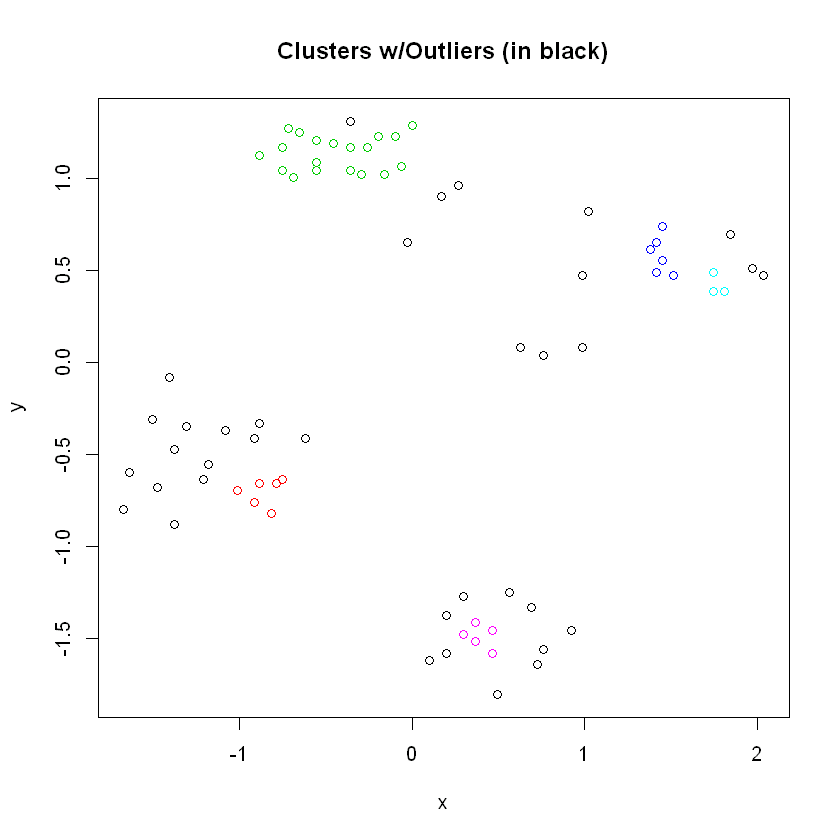

In [20]:
plot(scaledRuspini, col=db$cluster, main = "Clusters w/o Outliers")
plot(scaledRuspini, col=db$cluster+1L, main = "Clusters w/Outliers (in black)")

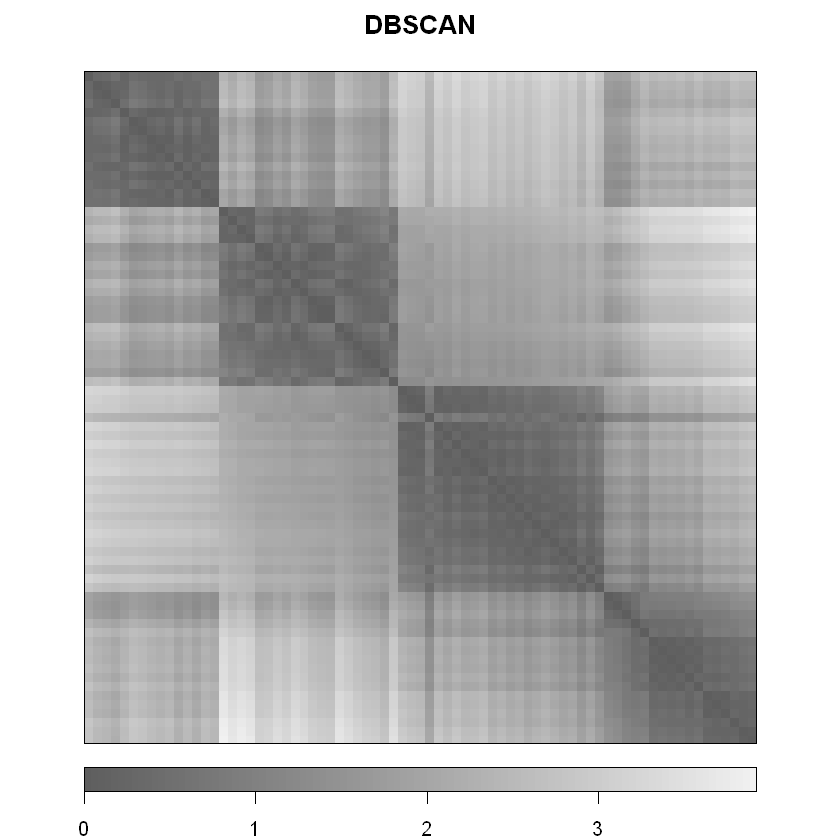

In [21]:
dissplot(dist(scaledRuspini), labels=db$clusters, options=list(main="DBSCAN"))

Dissimilarity plot above. Higher values = higher dissimilarity. Correspondingly, lower values = higher similarity.

#### Spectral Clustering
Spectral clustering techniques make use of the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The similarity matrix is provided as an input and consists of a quantitative assessment of the relative similarity of each pair of points in the dataset.

Partitioning may be done in various ways, such as by computing the median *m* of the components of the second smallest eigenvector *v*, and placing all points whose component in *v* is greater than *m* in B_1, and the rest in B_2. The algorithm can be used for hierarchical clustering by repeatedly partitioning the subsets in this fashion.

Alternatively to computing just one eigenvector, *k* eigenvectors for some *k* are computed, and then another algorithm (e.g. k-means clustering) is used to cluster points by their respective *k* components in these eigenvectors.

**Pros**

* Easy
* Generally good clustering results
* Does not make strong assumptions on statistics of clusters
* Fast for sparse data sets of thousands of elements

**Cons**

* Sensitive to parameter choices
* Computationally expensive for large data sets

Let's see an example. This time we'll use the spiral data set, which looks like this:

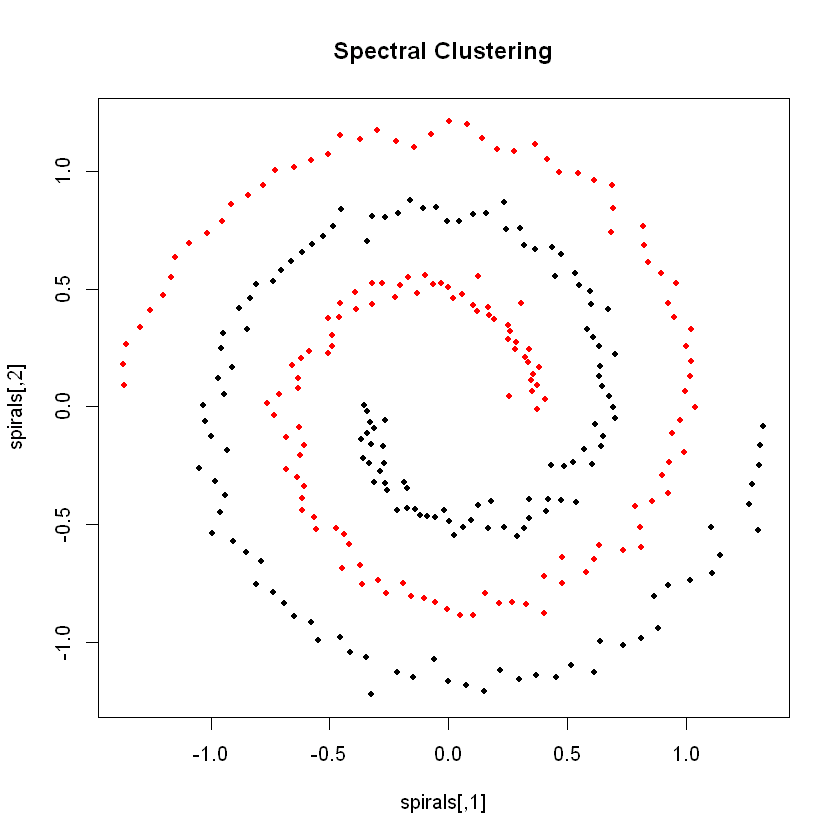

In [22]:
library(kernlab);
data(spirals)
sc <- specc(spirals, centers = 2)
plot(spirals, pch=20, col=sc, main = "Spectral Clustering")

Let's see how k-means would handle this data:

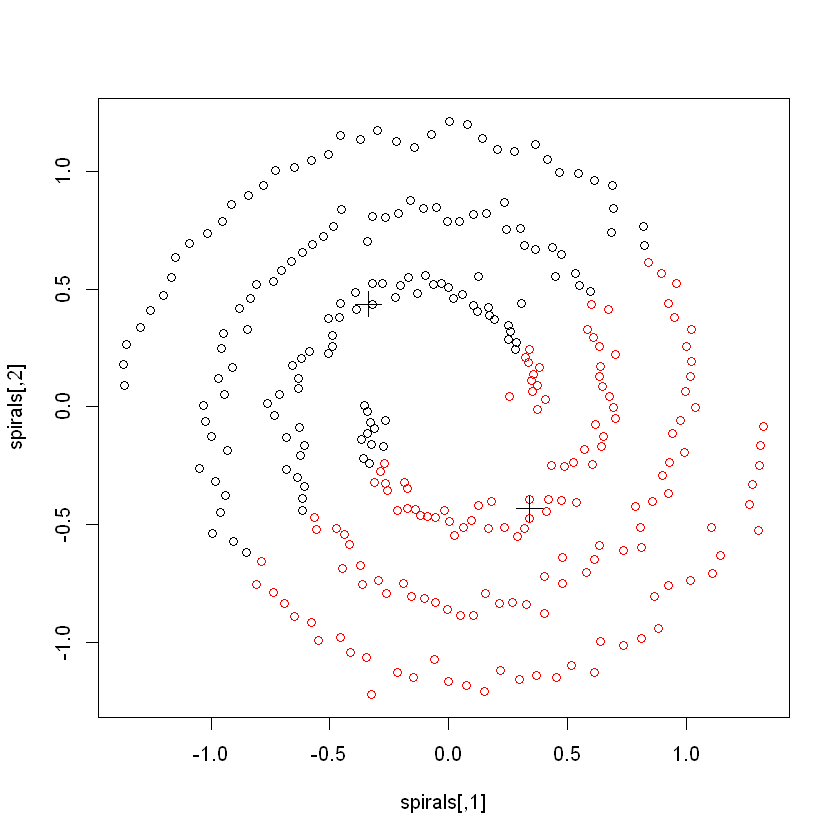

In [23]:
set.seed(42)
kmSpiral <- kmeans(spirals, centers = 2, nstart = 10)
plot(spirals, col=kmSpiral$cluster)
points(kmSpiral$centers, pch=3, cex=2) # add the centroids

Not very well it turns out! What's the lesson here? Know your data!

#### Gaussian Mixture Models (GMM)
In GMM's, each cluster is mathematically represented by a parametric distribution - Gaussian (continuous) or Poisson (discrete). The entire data set is modeled by a mixture of these distributions. An individual distribution used to model a specific cluster is called a component distribution.

**Pros**

* Well-studied statistical inference techniques available
* Flexibility in choosing component distributions
* Outputs a density estimation for each cluster
* "Soft" classification is available
* High likelihood models have high component distribution peaks and the model covers the data well

**Cons**

* May fail if dimensionality is too high
* User may have to set number of mixture models

We constrain GMM to find 4 clusters in this example.

----------------------------------------------------
Gaussian finite mixture model fitted by EM algorithm 
----------------------------------------------------

Mclust EEI (diagonal, equal volume and shape) model with 4 components:

 log.likelihood  n df       BIC       ICL
      -101.6027 75 13 -259.3327 -259.3356

Clustering table:
 1  2  3  4 
20 23 17 15 

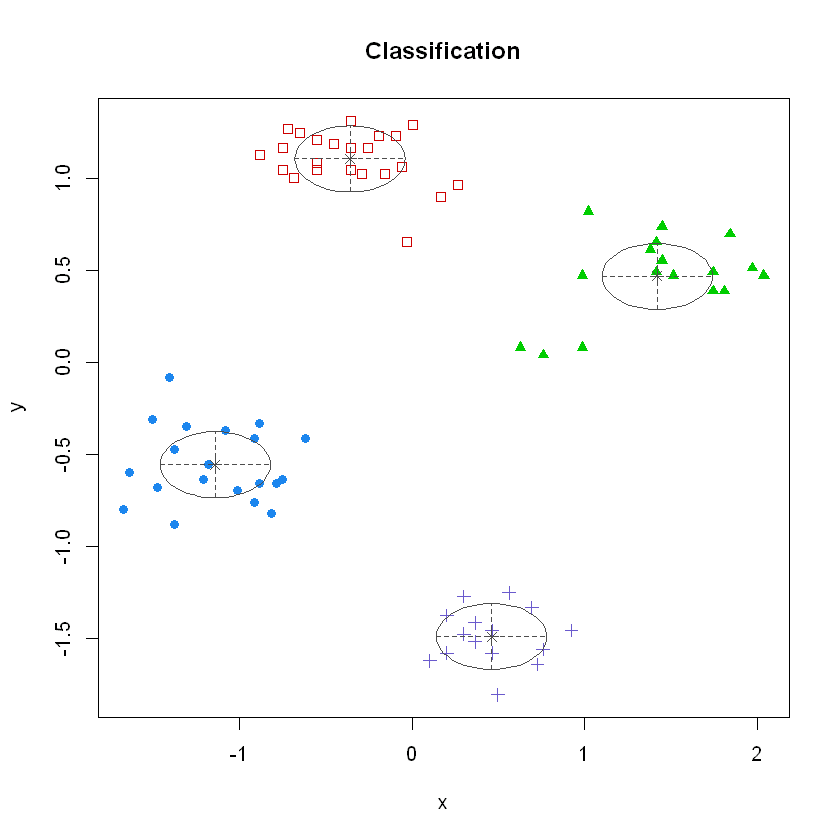

In [24]:
#library(mclust);
mc <- Mclust(scaledRuspini, G=4)
summary(mc)
plot(mc, what = "classification")

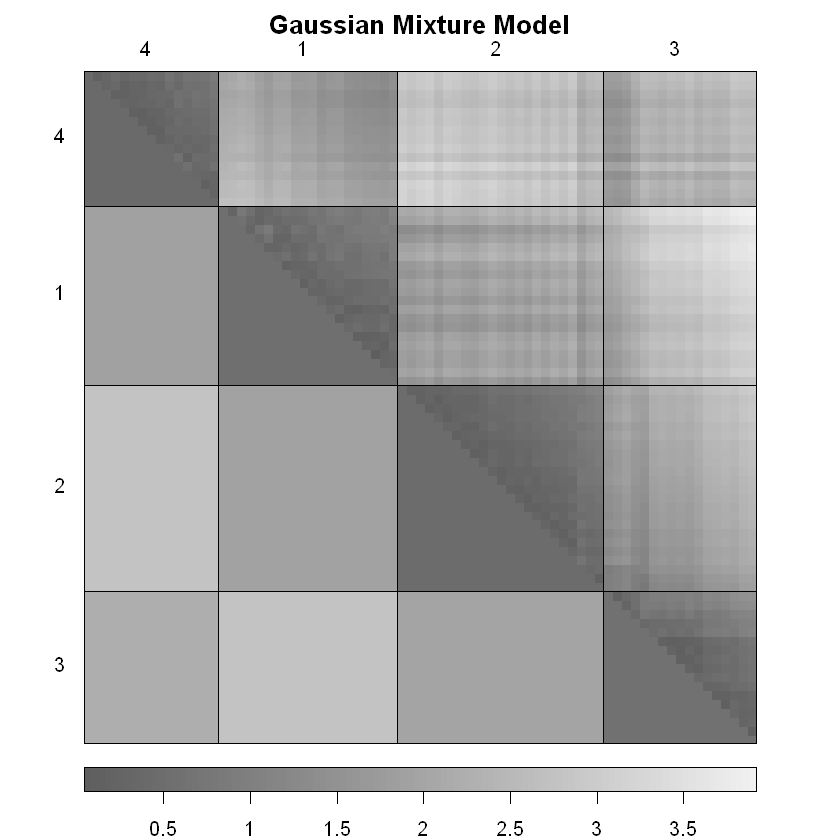

In [25]:
dissplot(dist(scaledRuspini), labels=mc$classification, options=list(main="Gaussian Mixture Model"))

Dissimilarity plot above. Higher values = higher dissimilarity. Correspondingly, lower values = higher similarity.

## Conclusion
I have proposed a three step process to unsupervised clustering: 1) investigate underlying data structure; 2) if strong structure exists, determine optimal number or most likely range of clusters; 3) implement appropriate clustering algorithm. We explored several methods to investigate underlying data structure. 

tSNE is a technique that maps high dimensional data into 2D or 3D for visual inspection. It does not necessarily provide us the number of clusters to target but we can see if the data is worth clustering. VAT is another visual technique available to us that helps determine if the data has underlying structure worth clustering.

If we discover in the first step that the data structure is not conducive to clustering, then we are done. No more analysis need be completed. If, however, there is structure, then we have some tools at our disposal to help us figure out how many clusters to target. The pamk algorithm (with CLARA for large data sets) allows us to investigate a range of *k* clusters and recommends the one with the greatest average silhouette width or Calinski-Harabasx index. For additional rigor, we can leverage up to 30 heuristic indices. Majority vote or some subset of indices can aid our discovery process. Lastly, we can utilize Gaussian Mixture Models, which will optimize via a user-selected metric (e.g. BIC) with the same effect. 

Now that we know or at least have a good idea how many clusters to target, we can implement a clustering algorithm. Many exist. Each has pros and cons. Some are fast. Some scale well. Some can handle non-linear structure or differing densities, even different shapes. A non-exhaustive list of pros and cons was included for the more common algorithms in this tutorial. 

Remember, there is no one-size-fits-all answer when it comes to unsupervised learning. The best we can do is know our data well and choose the tool best equipped to handle our particular data set. 